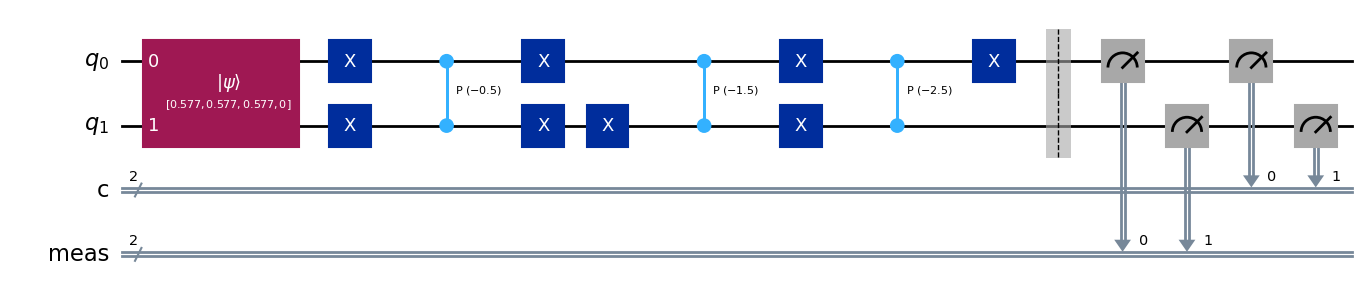

In [ ]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
import numpy as np
import math

simulator = AerSimulator()


omega = 1.0     # Frecuencia del oscilador
t = 1.0         # Tiempo de evolución
phi0 = -omega * t / 2         # Fase para |00⟩
phi1 = -3 * omega * t / 2     # Fase para |01⟩
phi2 = -5 * omega * t / 2     # Fase para |10⟩

# Crear circuito con 2 qubits y 2 bits clásicos
qc = QuantumCircuit(2, 2)

# 1. Preparar superposición inicial (puede incluir |11>)

psi = [math.sqrt(1/3), math.sqrt(1/3), math.sqrt(1/3), 0] 
qc.initialize(psi, [0, 1])  # Inicializar el estado |ψ⟩

# A continuación se aplicar la fase utilizando cp, una compuerta simétrica
# que solo aplica una fase al estado |11>. Para controlar, se utilizan Nots.

# Apply phase e^{iϕ0} to |00⟩
qc.x(0)
qc.x(1)
qc.cp(phi0, 0, 1)  # (masked |00⟩)
qc.x(1)
qc.x(0)

# Apply phase e^{iϕ1} to |01⟩
qc.x(1)
qc.cp(phi1, 0, 1)  #  (masked |01⟩)
qc.x(1)

# Apply phase e^{iϕ2} to |10⟩
qc.x(0)
qc.cp(phi2, 0, 1)  # (masked |10⟩)
qc.x(0)



qc.measure([0, 1], [0, 1])  # Medir ambos qubits


# Dibujar el circuito
qc.draw('mpl', fold=False)


In [119]:
from qiskit.visualization import plot_histogram

# Simular 1000 ejecuciones
job = simulator.run(qc, shots=1000)
result = job.result()
counts = result.get_counts(qc)

print(counts)



{'01 01': 323, '10 10': 357, '00 00': 320}


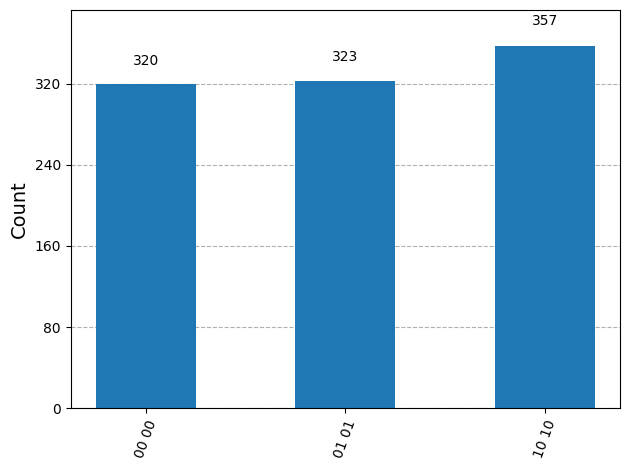

In [120]:
from qiskit.visualization import plot_histogram

plot_histogram(counts)